### 1. Importing packages

In [1]:
# If you'd like to install packages that are not installed by default, uncomment the last two lines of this cell and replace  with a list of your packages.
# This will ensure your notebook has all the dependencies and works everywhere
# import sys
# !{sys.executable} -m pip install matplotlib numpy pandas scipy sklearn statsmodels torch xgboost yfinance

In [2]:
import datetime
import random
import torch
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import xgboost as xgb
import yfinance as yf

from scipy.optimize import minimize
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.autograd import Variable

# plotting parameters
plt.rcParams['figure.figsize'] = (10,7)
plt.rcParams['axes.grid'] = True
plt.rcParams.update({'font.size': 12})

C:\Users\manuz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# disable auto-scrolling
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

### 2. Loading dataset

In [3]:
# tickers
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'NVDA', 'V', 'UNH', 
           'JNJ', 'BAC', 'WMT', 'HD', 'MA', 'XOM', 'PFE', 'DIS', 'CVX', 
           'PG', 'BRK-A', 'JPM', 'LLY', 'PEP', 'WFC', 'COST',
           'KO', 'AVGO', 'CSCO', 'ADBE'
           ]
tickers.sort()
# start and end data
start_time = datetime.datetime(2009, 12, 31) # 2009-12-31
end_time = datetime.datetime(2021, 12, 31) # 2021-12-31
# split training and validation datasets
all_split = 2516 # start 31/12/2009, val 02/01/2020, end 31/12/2021

In [4]:
# getting data
df = yf.download(tickers[0], start=start_time, end=end_time, progress=False)#
# keep index for pct changes (returns)
df = df.iloc[1:]
df.index = pd.to_datetime(df.index)
# dataframe for Adj Close price
act_adj_close_df_pct = pd.DataFrame(index=df.index, columns=tickers)
for ticker in tickers:
    stock_price_df = yf.download(ticker, start=start_time, end=end_time, progress=False)
    stock_price_df.index = pd.to_datetime(stock_price_df.index)
    act_adj_close_df_pct[ticker] = stock_price_df['Adj Close'].pct_change()

In [5]:
act_adj_close_df_pct.head()

,AAPL,ADBE,AMZN,AVGO,BAC,BRK-A,COST,CSCO,CVX,DIS,...,MSFT,NVDA,PEP,PFE,PG,UNH,V,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,0.015565,0.008429,-0.004609,0.031165,0.041833,0.004032,0.004056,0.031329,0.026887,-0.005581,...,0.015420,-0.010171,0.007237,0.040682,0.008082,0.034449,0.007775,0.012226,0.014593,0.014078
2010-01-05,0.001729,0.016446,0.005900,0.007424,0.032505,0.001104,-0.003030,-0.004456,0.007083,-0.002494,...,0.000323,0.014603,0.012084,-0.014263,0.000327,-0.001586,-0.011460,0.027453,-0.009958,0.003905
2010-01-06,-0.015907,-0.002122,-0.018116,0.007894,0.011729,0.001404,0.013000,-0.006509,0.000126,-0.005314,...,-0.006137,0.006396,-0.010003,-0.003216,-0.004744,0.009848,-0.013428,0.001425,-0.002235,0.008643
2010-01-07,-0.001848,-0.019405,-0.017013,-0.006266,0.032947,0.001502,-0.004833,0.004505,-0.003767,0.000314,...,-0.010400,-0.019597,-0.006356,-0.003764,-0.005424,0.038376,0.009307,0.036286,0.000560,-0.003142
2010-01-08,0.006648,-0.005422,0.027077,0.007357,-0.008860,0.003000,-0.007202,0.005299,0.001765,0.001571,...,0.006897,0.002161,-0.003280,0.008095,-0.001321,-0.009391,0.002766,-0.009269,-0.005038,-0.004012


In [6]:
act_adj_close_df_pct.tail()

,AAPL,ADBE,AMZN,AVGO,BAC,BRK-A,COST,CSCO,CVX,DIS,...,MSFT,NVDA,PEP,PFE,PG,UNH,V,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-23,0.003644,0.010000,0.000184,0.014652,0.003162,0.000148,0.001273,0.012189,0.002411,0.011522,...,0.004472,0.008163,-0.001118,-0.014106,0.004896,0.002530,-0.006148,0.006871,-0.002218,0.000492
2021-12-27,0.022975,0.014150,-0.008178,0.014260,0.004953,0.005523,0.023802,0.018304,0.020445,-0.005403,...,0.023186,0.044028,0.009954,0.008346,0.011680,0.008317,0.004663,0.008478,0.009104,0.014258
2021-12-28,-0.005767,-0.014402,0.005844,-0.007830,0.001344,0.005502,0.002076,0.001735,-0.001936,0.015707,...,-0.003504,-0.020133,0.005190,-0.020101,0.005371,0.006887,0.001930,-0.007177,0.014351,-0.003232
2021-12-29,0.000502,-0.000123,-0.008555,0.005396,-0.001566,0.005632,0.005543,0.006768,-0.005145,-0.002126,...,0.002051,-0.010586,0.003539,-0.007412,0.008290,0.005249,0.000550,0.000619,-0.000490,-0.008753
2021-12-30,-0.006578,0.002178,-0.003289,-0.011195,-0.002241,0.001323,-0.006799,-0.005316,-0.004409,0.006844,...,-0.007691,-0.013833,-0.001734,0.014241,-0.008648,-0.002275,-0.001375,-0.007224,0.003223,-0.005887


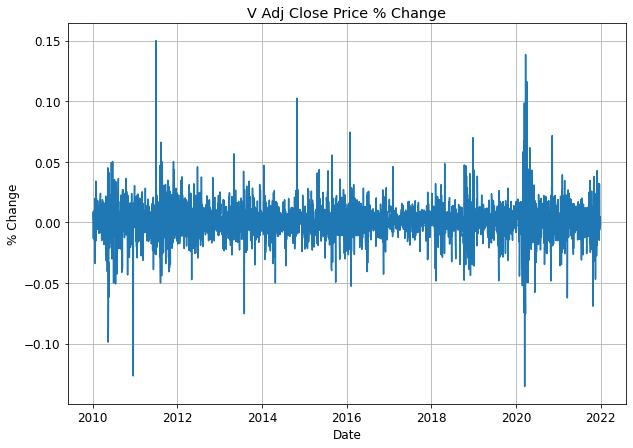

In [7]:
# plotting Adj Close price distribution of random ticker
rand_ticker = random.choice(tickers)
plt.plot(act_adj_close_df_pct[rand_ticker].index, act_adj_close_df_pct[rand_ticker])
plt.xlabel('Date')
plt.ylabel('% Change')
plt.title(f'{rand_ticker} Adj Close Price % Change')
plt.show()
# save locally
# act_adj_close_df.to_csv('data/act-adj-close-df.csv')

### 3. Building LSTM model

In [8]:
# selecting gpu
# device = torch.device('cuda')
device = torch.device('cpu')

In [9]:
class LSTM_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM_model, self).__init__()
        self.input_size = input_size # number of features
        self.hidden_size = hidden_size # number of features in hidden state
        self.num_layers = num_layers # number of stacked LSTM layers
        self.num_classes = num_classes # number of output classes
    
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True) # LSTM layer
        self.fc = nn.Linear(hidden_size, num_classes) # fully connected last layer

    def forward(self, x):
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), 
                                  self.hidden_size)).to(device) # hidden state
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), 
                                  self.hidden_size)).to(device) # internal state
        # propagating input through LSTM
        out, _ = self.lstm(x, (h0, c0)) # out: tensor of shape (seq_length, batch_size, hidden_size)
        # decoding hidden state of last time step
        out = self.fc(out[:, -1, :])
        return out

In [10]:
# function for building model
def build_model(input_size=1, hidden_size=2, num_layers=2, num_classes=1, learning_rate=0.01):
    # learning rate controls how much to change model in response to lstm error each time model weights are updated
    
    model = LSTM_model(input_size, hidden_size, num_layers, num_classes).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # adam optimizer
    # algorithms/methods to change attributes of neural network such as weights and learning rate to reduce losses

    # loss function measures how bad model performs: high loss -> low accuracy
    loss_function = torch.nn.MSELoss()
    """
    Creates a criterion that measures the mean squared error (squared L2 norm) between each element in the input x and target y.
    """
    # loss_function = torch.nn.L1Loss()
    """
    Creates a criterion that measures the mean absolute error (MAE) between each element in the input x and target y.
    """
    

    return model, optimizer, loss_function

### 4. Model fitting and evaluation

In [11]:
# function for creating X and y
def create_xy(data, time_step=1):
    """
    This function creates the x data that should be used to predict y data.
    As we can see, time_step=1, which means that to predict y, we observe the last x value only.
    TODO: use different values of time_step>1 to see if it works and improves predictions.
    """
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:i + time_step])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

In [12]:
# scaler for normalizing dataset
scaler = StandardScaler()
# dataframes for model loss, predicted Adj Close price % change and model performance
time_step = 10#100
num_epochs = 10000# number of epochs
num_steps_eval = 1000# number of steps to evaluate
model_loss_df = pd.DataFrame(index=[epoch for epoch in range(0, num_epochs+num_steps_eval, num_steps_eval)], columns=tickers)
model_loss_val_df = pd.DataFrame(index=[epoch for epoch in range(0, num_epochs+num_steps_eval, num_steps_eval)], columns=tickers)
pred_adj_close_df_pct = pd.DataFrame(index=df.index[time_step + 1:], columns=tickers)
XGB_pred_adj_close_df_pct = pd.DataFrame(index=df.index[time_step + 1:], columns=tickers)
model_perf_df = pd.DataFrame(index=['MAE', 'MSE', 'RMSE'], columns=tickers)

In [13]:
# functions for model performance evaluation
def MAE(y_true, y_hat):
    return np.mean(np.abs(y_true - y_hat))

def MSE(y_true, y_hat):
    return np.mean(np.square(y_true - y_hat))

def RMSE(y_true, y_hat):
    return np.sqrt(MSE(y_true, y_hat))

In [14]:
# function for fitting model
def fit_model(ticker, X_train, y_train, num_epochs, X_test, y_test, eps_tol=1e-4):
    model, optimizer, loss_function = build_model()
    
    loss_list = []
    loss_val_list = []

    for epoch in range(num_epochs + 1):
        outputs = model.forward(X_train.to(device)) # forward pass
        optimizer.zero_grad() # calculating gradient, manually setting to 0
        loss = loss_function(outputs, y_train.to(device)) # obtaining loss
        loss.backward() # calculating loss of loss function
        optimizer.step() # improving from loss, i.e. backprop
        
        # store training information at every steps (num_steps_eval)
        if epoch % num_steps_eval == 0:
            loss_list.append(loss.item())
            outputs_val = model.forward(X_test.to(device)) # forward pass
            loss_val = loss_function(outputs_val, y_test.to(device)) # obtaining loss
            loss_val.backward() # calculating loss of loss function
            loss_val_list.append(loss_val.item())
        
        # exit when low error:
        if (loss_val<eps_tol) or (loss<eps_tol):
            print(f"Exiting {ticker} training due to loss tolerance.")
            break
    
    # store in-sample loss and validation loss
    model_loss_df[ticker] = loss_list
    model_loss_val_df[ticker] = loss_val_list

    # saving model state
    torch.save(model.state_dict(), f'model-states/{ticker}-model-state.pth')
    
    return model

In [15]:
# LSTM fitting models and predicting responses
for ticker in tickers:
    # scale with training data only
    train_set = scaler.fit_transform(np.array(act_adj_close_df_pct[ticker][:all_split]).reshape(-1, 1))
    # here val_set is the entire set, then later we only test on exclusive validation period
    val_set = scaler.transform(np.array(act_adj_close_df_pct[ticker]).reshape(-1, 1))

    X_train, y_train = create_xy(train_set, time_step)
    X_val, y_val = create_xy(val_set, time_step)

    # converting datasets to tensors
    X_train_tensors = Variable(torch.Tensor(X_train))
    y_train_tensors = Variable(torch.Tensor(y_train))

    X_val_tensors = Variable(torch.Tensor(X_val))
    y_test = Variable(torch.Tensor(y_val))
    y_true = scaler.inverse_transform(y_val) # inverse transformation
    
    # fitting model
    print('----------')
    print(f'{ticker} fitting...')
    model = fit_model(ticker=ticker, X_train=X_train_tensors, y_train=y_train_tensors, num_epochs=num_epochs,
                    X_test=X_val_tensors, y_test=y_test)

    # predicting response
    y_hat = model(X_val_tensors.to(device)) # forward pass
    y_hat = y_hat.data.detach().cpu().numpy() # numpy conversion
    y_hat = scaler.inverse_transform(y_hat) # inverse transformation
    print('Done!')
    
    pred_adj_close_df_pct[ticker] = y_hat
    
    model_perf_df[ticker] = [MAE(y_true, y_hat), MSE(y_true, y_hat), RMSE(y_true, y_hat)]

----------
AAPL fitting...
Done!
----------
ADBE fitting...
Done!
----------
AMZN fitting...
Done!
----------
AVGO fitting...
Done!
----------
BAC fitting...
Done!
----------
BRK-A fitting...
Done!
----------
COST fitting...
Done!
----------
CSCO fitting...
Done!
----------
CVX fitting...
Done!
----------
DIS fitting...
Done!
----------
GOOG fitting...
Done!
----------
HD fitting...
Done!
----------
JNJ fitting...
Done!
----------
JPM fitting...
Done!
----------
KO fitting...
Done!
----------
LLY fitting...
Done!
----------
MA fitting...
Done!
----------
MSFT fitting...
Done!
----------
NVDA fitting...
Done!
----------
PEP fitting...
Done!
----------
PFE fitting...
Done!
----------
PG fitting...
Done!
----------
UNH fitting...
Done!
----------
V fitting...
Done!
----------
WFC fitting...
Done!
----------
WMT fitting...
Done!
----------
XOM fitting...
Done!


### 5. Results

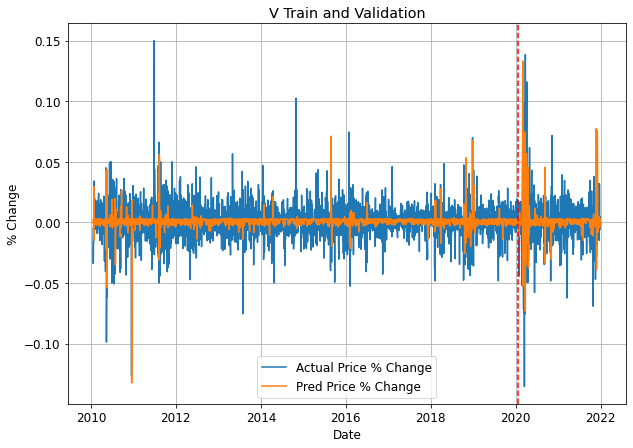

In [16]:
# plotting actual and predicted Adj Close price of random ticker
plt.plot(pred_adj_close_df_pct.index, act_adj_close_df_pct[rand_ticker][time_step + 1:], label='Actual Price % Change')
plt.plot(pred_adj_close_df_pct.index, pred_adj_close_df_pct[rand_ticker], label='Pred Price % Change')
# plt.plot(pred_adj_close_df_pct.index, act_adj_close_df_pct['PG'][time_step + 1:], label='Actual Price % Change')
# plt.plot(pred_adj_close_df_pct.index, pred_adj_close_df_pct['PG'], label='Pred Price % Change')
plt.axvline(x=pred_adj_close_df_pct.index[all_split], c='r', linestyle='--')
plt.xlabel('Date')
plt.ylabel('% Change')
plt.title(f'{rand_ticker} Train and Validation')
plt.legend()
plt.show()

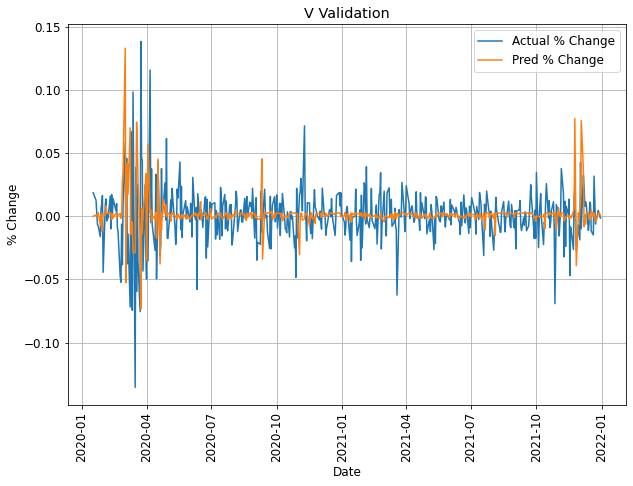

In [17]:
val_act = act_adj_close_df_pct[rand_ticker][time_step + 1 + all_split:]
val_pred = pred_adj_close_df_pct[rand_ticker][all_split:]
# val_act = act_adj_close_df_pct['PG'][time_step + 1 + all_split:]
# val_pred = pred_adj_close_df_pct['PG'][all_split:]

plt.plot(pred_adj_close_df_pct.index[all_split:], val_act, label='Actual % Change')
plt.plot(pred_adj_close_df_pct.index[all_split:], val_pred, label='Pred % Change')
plt.xlabel('Date')
plt.ylabel('% Change')
plt.title(f'{rand_ticker} Validation')
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [18]:
model_loss_df.tail()

,AAPL,ADBE,AMZN,AVGO,BAC,BRK-A,COST,CSCO,CVX,DIS,...,MSFT,NVDA,PEP,PFE,PG,UNH,V,WFC,WMT,XOM
6000,0.943940,0.901887,0.892091,0.906949,0.996666,0.871134,0.903604,0.884924,0.892444,0.888048,...,0.884894,0.853265,0.984772,0.869646,0.893174,0.902629,0.910871,0.830126,0.870616,0.882068
7000,0.966962,0.899125,0.892604,0.892763,0.903351,0.870171,0.907839,0.884927,0.891977,0.887661,...,0.886616,0.849296,0.966229,0.869895,0.889366,0.901411,0.895420,0.837907,0.878205,0.878148
8000,0.978237,0.902805,0.891978,0.898725,0.983514,0.869610,0.903107,0.885005,0.891948,0.883038,...,0.887663,0.840771,0.956464,0.867562,0.881146,0.908512,0.884748,0.830046,0.870820,0.885209
9000,0.958863,0.906577,0.891549,0.897735,0.969409,0.868786,0.902646,0.885052,0.903368,0.909682,...,0.886201,0.839212,0.953995,0.867712,0.880319,0.899407,0.880445,0.831754,0.867870,0.878831
10000,0.947659,0.899285,0.889881,0.896704,0.965164,0.868975,0.912824,0.884972,0.889494,0.882416,...,0.884828,0.838362,0.957965,0.866067,0.880536,0.897544,0.877018,0.830531,0.867180,0.875370


In [19]:
model_loss_val_df.tail()

,AAPL,ADBE,AMZN,AVGO,BAC,BRK-A,COST,CSCO,CVX,DIS,...,MSFT,NVDA,PEP,PFE,PG,UNH,V,WFC,WMT,XOM
6000,1.144606,1.095144,0.957308,1.002818,1.170191,1.121021,1.100116,1.028246,1.578891,1.350252,...,1.097140,1.103762,1.488816,1.320251,1.265673,1.205132,1.142411,1.510986,1.112943,1.755393
7000,1.157255,1.093203,0.957834,0.992408,1.099126,1.117995,1.098581,1.027672,1.580038,1.344962,...,1.094631,1.076057,1.479422,1.314082,1.263572,1.203954,1.141913,1.510681,1.121596,1.749050
8000,1.163283,1.101308,0.957575,0.993342,1.148158,1.116055,1.102706,1.026307,1.580573,1.342242,...,1.095335,1.085393,1.482554,1.302234,1.259935,1.210584,1.171245,1.511247,1.123534,1.741117
9000,1.162393,1.094952,0.956737,0.993408,1.153079,1.116414,1.098293,1.026592,1.580895,1.359863,...,1.095823,1.091660,1.477615,1.293720,1.262882,1.202909,1.175724,1.511107,1.126128,1.746797
10000,1.162378,1.095133,0.956594,0.993121,1.138097,1.113554,1.102741,1.025276,1.573919,1.354513,...,1.097715,1.099746,1.484912,1.293814,1.265184,1.200398,1.198269,1.509269,1.132913,1.752146


In [20]:
model_perf_df

,AAPL,ADBE,AMZN,AVGO,BAC,BRK-A,COST,CSCO,CVX,DIS,...,MSFT,NVDA,PEP,PFE,PG,UNH,V,WFC,WMT,XOM
MAE,0.012237,0.012535,0.013229,0.015152,0.014793,0.007959,0.008277,0.010456,0.010836,0.010240,...,0.010329,0.018384,0.007055,0.009034,0.007016,0.010715,0.010863,0.012170,0.007656,0.010262
MSE,0.000306,0.000342,0.000364,0.000454,0.000477,0.000135,0.000140,0.000257,0.000277,0.000238,...,0.000225,0.000717,0.000119,0.000172,0.000110,0.000249,0.000261,0.000346,0.000134,0.000239
RMSE,0.017483,0.018492,0.019079,0.021311,0.021852,0.011601,0.011848,0.016030,0.016647,0.015424,...,0.014993,0.026782,0.010898,0.013133,0.010491,0.015771,0.016140,0.018602,0.011565,0.015456


### 6. Extension: XGBoost

In [21]:
# XGBoost fitting models and predicting responses for XGBoost
for ticker in tickers:
    # scale with training data only
    train_set = scaler.fit_transform(np.array(act_adj_close_df_pct[ticker][:all_split]).reshape(-1, 1))
    # here val_set is the entire set, then later we only test on exclusive validation period
    val_set = scaler.transform(np.array(act_adj_close_df_pct[ticker]).reshape(-1, 1))

    X_train, y_train = create_xy(train_set, time_step)
    X_val, y_val = create_xy(val_set, time_step)
    
    # fitting XGBoost model
    print('----------')
    print(f'{ticker} fitting...')
    reg = xgb.XGBRegressor(objective='reg:squarederror')
    #, n_estimators=100
    # , n_estimators=1000
    # , max_depth=5, learning_rate=0.1, gamma=0.01, subsample=0.9
    reg.fit(np.squeeze(X_train), y_train,#
            verbose=False)  # Change verbose to True if you want to see it train

    # predicting response
    y_hat = reg.predict(np.squeeze(X_val))
    y_hat = scaler.inverse_transform(y_hat.reshape(-1, 1)) # inverse transformation
    print('Done!')
    
    XGB_pred_adj_close_df_pct[ticker] = y_hat

----------
AAPL fitting...
Done!
----------
ADBE fitting...
Done!
----------
AMZN fitting...
Done!
----------
AVGO fitting...
Done!
----------
BAC fitting...
Done!
----------
BRK-A fitting...
Done!
----------
COST fitting...
Done!
----------
CSCO fitting...
Done!
----------
CVX fitting...
Done!
----------
DIS fitting...
Done!
----------
GOOG fitting...
Done!
----------
HD fitting...
Done!
----------
JNJ fitting...
Done!
----------
JPM fitting...
Done!
----------
KO fitting...
Done!
----------
LLY fitting...
Done!
----------
MA fitting...
Done!
----------
MSFT fitting...
Done!
----------
NVDA fitting...
Done!
----------
PEP fitting...
Done!
----------
PFE fitting...
Done!
----------
PG fitting...
Done!
----------
UNH fitting...
Done!
----------
V fitting...
Done!
----------
WFC fitting...
Done!
----------
WMT fitting...
Done!
----------
XOM fitting...
Done!


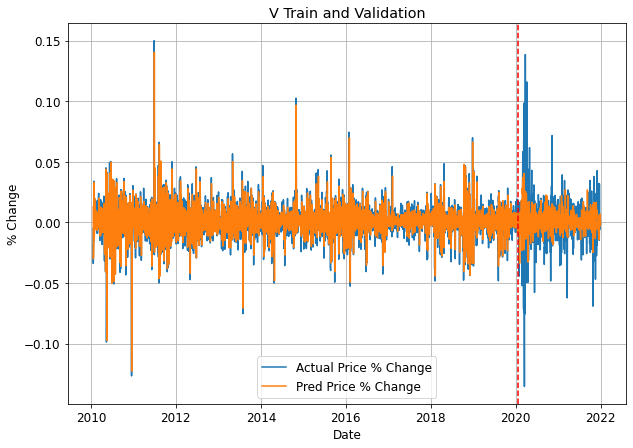

In [22]:
# plotting actual and predicted Adj Close price of random ticker
plt.plot(XGB_pred_adj_close_df_pct.index, act_adj_close_df_pct[rand_ticker][time_step + 1:], label='Actual Price % Change')
plt.plot(XGB_pred_adj_close_df_pct.index, XGB_pred_adj_close_df_pct[rand_ticker], label='Pred Price % Change')
# plt.plot(pred_adj_close_df_pct.index, act_adj_close_df_pct['AAPL'][time_step + 1:], label='Actual Price % Change')
# plt.plot(pred_adj_close_df_pct.index, XGB_pred_adj_close_df_pct['AAPL'], label='Pred Price % Change')
plt.axvline(x=XGB_pred_adj_close_df_pct.index[all_split], c='r', linestyle='--')
plt.xlabel('Date')
plt.ylabel('% Change')
plt.title(f'{rand_ticker} Train and Validation')
plt.legend()
plt.show()

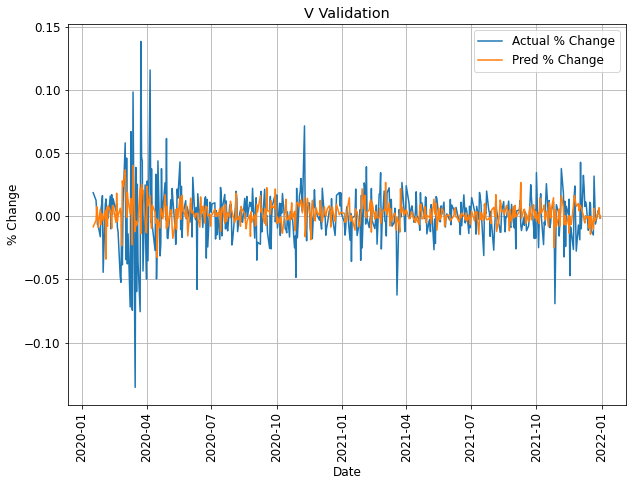

In [23]:
val_act = act_adj_close_df_pct[rand_ticker][time_step + 1 + all_split:]
val_pred = XGB_pred_adj_close_df_pct[rand_ticker][all_split:]
# val_act = act_adj_close_df_pct['PG'][time_step + 1 + all_split:]
# val_pred = pred_adj_close_df_pct['PG'][all_split:]

plt.plot(XGB_pred_adj_close_df_pct.index[all_split:], val_act, label='Actual % Change')
plt.plot(XGB_pred_adj_close_df_pct.index[all_split:], val_pred, label='Pred % Change')
plt.xlabel('Date')
plt.ylabel('% Change')
plt.title(f'{rand_ticker} Validation')
plt.legend()
plt.xticks(rotation=90)
plt.show()

### 7. Building portfolios

In [24]:
# daily returns of actual Adj Close price (validation phase)
act_adj_close_val_df_pct = act_adj_close_df_pct.iloc[time_step + 1 + all_split:, :]
act_daily_ret_df = act_adj_close_val_df_pct#.pct_change()
act_daily_ret_df = act_daily_ret_df.iloc[1:, :]
act_daily_ret_df.head()

,AAPL,ADBE,AMZN,AVGO,BAC,BRK-A,COST,CSCO,CVX,DIS,...,MSFT,NVDA,PEP,PFE,PG,UNH,V,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-21,-0.006777,0.000743,0.014630,-0.002332,-0.012964,-0.006725,0.028161,-0.004488,-0.019640,-0.005335,...,-0.003591,-0.005375,0.004248,-0.004196,-0.002531,0.006902,0.012653,-0.004880,0.005480,-0.014294
2020-01-22,0.003569,0.000171,-0.002400,0.015905,0.002919,0.005983,-0.004373,0.005533,-0.003618,0.003135,...,-0.004805,0.008752,0.010715,-0.003718,0.001745,0.000199,0.002943,-0.007765,0.004412,-0.005771
2020-01-23,0.004816,0.004856,-0.001526,0.021344,-0.006985,-0.000830,0.003174,-0.001427,0.001771,-0.012569,...,0.006156,0.010995,0.001883,0.012938,-0.004572,-0.003759,-0.006638,-0.007002,-0.002498,-0.006251
2020-01-24,-0.002882,-0.001109,-0.012172,0.013609,-0.016999,-0.012238,-0.007575,-0.003061,-0.011052,-0.014909,...,-0.010077,-0.009412,-0.005082,-0.021862,0.001200,-0.022206,-0.007360,-0.013480,-0.012434,-0.006739
2020-01-27,-0.029405,-0.012722,-0.017887,-0.046204,-0.020573,-0.019336,-0.003414,-0.028250,-0.013053,-0.029840,...,-0.016723,-0.041041,-0.005458,0.008538,0.004395,-0.029780,-0.016146,-0.009880,0.013028,-0.023824


In [25]:
# dataframe for daily portfolio returns
act_daily_port_ret_df = act_daily_ret_df.copy()
act_daily_port_ret_df.drop(columns=tickers, inplace=True)

In [26]:
# risk free return
risk_free_ret = 0.000
# risk_free_ret = 0.015

#### Equally weighted portfolio

In [27]:
n_assets = len(tickers)
eq_weights = np.ones(n_assets) / n_assets
act_daily_port_ret_df[f'Pred Eq Return'] = act_adj_close_df_pct.dot(eq_weights)
act_daily_port_ret_df[f'Eq Cum Prod Return'] = (1 + act_daily_port_ret_df[f'Pred Eq Return']).cumprod()

avgret_eq = act_daily_port_ret_df[f'Pred Eq Return'].mean()
stdret_eq = act_daily_port_ret_df[f'Pred Eq Return'].std()
sharpe_ratio_eq = round((avgret_eq - risk_free_ret) / stdret_eq,2)

print('Eq')
print('Weights:')
print(eq_weights)
sum(eq_weights)

Eq
Weights:
[0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
 0.03703704 0.03703704 0.03703704]


0.9999999999999993

#### LSTM predictions portfolio

In [28]:
# function for getting inverse of expected return using predicted Adj Close price
# used to get optimum weights that maximize this expected return
def exp_ret_inv(weights, pred):
    # pred_daily_port_ret = pred.dot(weights)
    # exp_ret = pred_daily_port_ret.mean()
    # return 1 / exp_ret
    return -np.sum(pred.dot(weights))

In [29]:
# LSTM expected return maximization using predicted Adj Close price
weights0 = eq_weights # initial weightswe
# bounds: weight should be between 0.0 and 1.0
bnds = tuple((0.0, 1.0) for i in range(n_assets))
# constraints: weights should add up to 1.0
cons = ({'type': 'eq', 'fun': lambda W: np.sum(W) - 1.0})

print('Pred LSTM')
for t in range(len(pred_adj_close_df_pct)-all_split-1):
    res = minimize(exp_ret_inv, weights0, args=(pred_adj_close_df_pct.iloc[t+all_split+1],), method='SLSQP', bounds=bnds, constraints=cons)
    pred_weights = res.x
    act_daily_port_ret_df[f'Pred LSTM Return'] = act_daily_ret_df.dot(pred_weights)
    act_daily_port_ret_df[f'Pred LSTM Return'].iloc[t] = act_adj_close_df_pct.iloc[t+all_split+1].dot(pred_weights)
    act_daily_port_ret_df[f'Pred LSTM Return'].iloc[t] = act_daily_port_ret_df[f'Pred LSTM Return'].iloc[t] - 0.0003
    print(pred_weights)
    
act_daily_port_ret_df[f'Pred LSTM Cum Prod Return'] = (1 + act_daily_port_ret_df[f'Pred LSTM Return']).cumprod()

avgret_lstm = act_daily_port_ret_df[f'Pred LSTM Return'].mean()#
stdret_lstm = act_daily_port_ret_df[f'Pred LSTM Return'].std()
sharpe_ratio_lstm = round((avgret_lstm - risk_free_ret) / stdret_lstm,2)

sum(pred_weights)

Pred LSTM
[0.00000000e+00 2.04753520e-17 5.74867897e-17 2.34193286e-17
 0.00000000e+00 1.49349698e-17 3.19127176e-19 4.87715088e-17
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.80575674e-17 2.96745863e-01 4.20012656e-17 0.00000000e+00
 2.17888538e-17 0.00000000e+00 4.75825639e-01 0.00000000e+00
 1.55914938e-17 0.00000000e+00 2.27428498e-01 0.00000000e+00
 3.73199005e-18 0.00000000e+00 1.75094645e-18]
[2.32293331e-16 0.00000000e+00 0.00000000e+00 2.01347217e-16
 9.24666402e-17 9.83793969e-17 8.73233868e-17 1.22968072e-16
 1.96864083e-16 6.88814269e-17 7.66934469e-17 1.22971073e-16
 8.95701953e-17 8.25412348e-17 5.85124292e-17 1.05826435e-16
 3.75305503e-17 2.05005299e-16 1.00000000e+00 7.40023203e-17
 8.75940670e-17 3.41494420e-17 9.33806063e-17 8.17006409e-17
 6.89118701e-17 7.83077079e-17 7.43704695e-17]
[0.00000000e+00 0.00000000e+00 2.44359316e-01 0.00000000e+00
 9.51428581e-17 4.30531222e-17 2.71067228e-17 0.00000000e+00
 8.67950392e-17 0.00000000e+00 0.00000000e

1.0

#### XGBoost predictions portfolio

In [30]:
# XGBoost expected return maximization using predicted Adj Close price
print('Pred XGBoost')
for t in range(len(XGB_pred_adj_close_df_pct)-all_split-1):
    res = minimize(exp_ret_inv, weights0, args=(XGB_pred_adj_close_df_pct.iloc[t+all_split+1],), method='SLSQP', bounds=bnds, constraints=cons)
    pred_weights = res.x
    act_daily_port_ret_df[f'Pred XGBoost Return'] = act_daily_ret_df.dot(pred_weights)
    act_daily_port_ret_df[f'Pred XGBoost Return'].iloc[t] = act_adj_close_df_pct.iloc[t+all_split+1].dot(pred_weights)
    act_daily_port_ret_df[f'Pred XGBoost Return'].iloc[t] = act_daily_port_ret_df[f'Pred XGBoost Return'].iloc[t] - 0.0003
    print(pred_weights)
    
act_daily_port_ret_df[f'Pred XGBoost Cum Prod Return'] = (1 + act_daily_port_ret_df[f'Pred XGBoost Return']).cumprod()

avgret_xgb = act_daily_port_ret_df[f'Pred XGBoost Return'].mean()
stdret_xgb = act_daily_port_ret_df[f'Pred XGBoost Return'].std()
sharpe_ratio_xgb = round((avgret_xgb - risk_free_ret) / stdret_xgb,2)

sum(pred_weights)

Pred XGBoost
[0.00000000e+00 2.86843117e-20 0.00000000e+00 5.14850368e-17
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.57476113e-17
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00]
[0.00000000e+00 1.33226763e-15 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.46638392e-17 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.35619412e-16
 0.00000000e+00 0.00000000e+00 1.50046146e-16 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.26927033e-16
 2.19203614e-16 0.00000000e+00 1.00000000e+00]
[0.00000000e+00 2.34881887e-17 2.85521918e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 5.20417043e-17 2.64103480e-16
 0.00000000e+00 0.00000000e+00 0.000000

1.000000000000001

#### Plotting cummulative product returns

In [31]:
act_daily_port_ret_df

,Pred Eq Return,Eq Cum Prod Return,Pred LSTM Return,Pred LSTM Cum Prod Return,Pred XGBoost Return,Pred XGBoost Cum Prod Return
Date,,,,,,
2020-01-21,-0.000521,0.999479,-0.005375,0.994625,-0.002752,0.997248
2020-01-22,0.001706,1.001184,0.008752,1.003330,0.005073,1.002307
2020-01-23,0.000809,1.001994,0.010995,1.014361,0.008363,1.010689
2020-01-24,-0.009049,0.992927,-0.009412,1.004814,-0.005852,1.004775
2020-01-27,-0.014900,0.978132,-0.041041,0.963575,-0.028899,0.975738
...,...,...,...,...,...,...
2021-12-23,0.003984,1.607705,0.008163,4.768107,0.008951,3.097543
2021-12-27,0.011742,1.626583,0.044028,4.978039,0.031217,3.194240
2021-12-28,-0.000690,1.625460,-0.020133,4.877818,-0.017676,3.137780


In [32]:
adoi = pred_adj_close_df_pct.index[all_split] - datetime.timedelta(days=1)
print(f'Assumed Date of Investment: {adoi.date()}')

Assumed Date of Investment: 2020-01-16


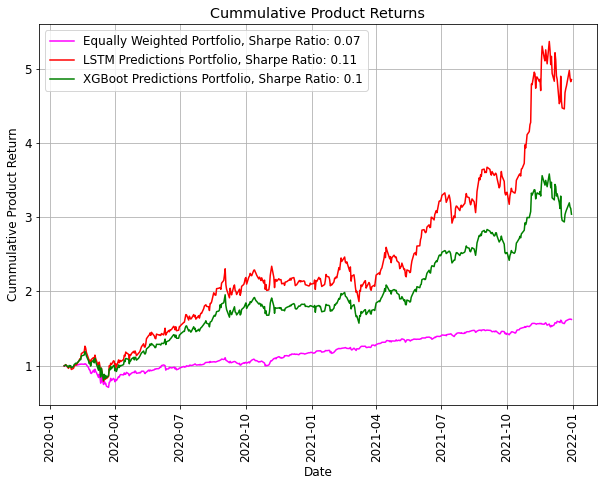

In [33]:
plt.plot(act_daily_port_ret_df.index, act_daily_port_ret_df['Eq Cum Prod Return'], 
         label=f'Equally Weighted Portfolio, Sharpe Ratio: {sharpe_ratio_eq}', color='fuchsia')
plt.plot(act_daily_port_ret_df.index, act_daily_port_ret_df['Pred LSTM Cum Prod Return'], 
         label=f'LSTM Predictions Portfolio, Sharpe Ratio: {sharpe_ratio_lstm}', color='red')
plt.plot(act_daily_port_ret_df.index, act_daily_port_ret_df['Pred XGBoost Cum Prod Return'], 
         label=f'XGBoot Predictions Portfolio, Sharpe Ratio: {sharpe_ratio_xgb}', color='green')
plt.xlabel('Date')
plt.ylabel('Cummulative Product Return')
plt.title('Cummulative Product Returns')
plt.legend()
plt.xticks(rotation=90)
plt.show()